In [1]:
import numpy as np
import fjlt
from sklearn.random_projection import johnson_lindenstrauss_min_dim, GaussianRandomProjection
import matplotlib.pyplot as plt
import time

In a nutshell, `fjlt_sfd` works best and it needs only numpy. Just use the code below as needed.

# Test different embedding methods

In [2]:
def calc_dist(x1, x2):
    """
    l2-distance between points x1 and x2.
    """
    return np.linalg.norm(x1 - x2)

def eval_dist(A, A_embedded):
    """
    Calculate l2 distances between points (column vectors) for the original matrix A
    and the embedded matrix A_embedded. Calculate only for the pairs of points of adjacent 
    indices (it's simple this way).
    """
    N = A.shape[1]
    dist = np.zeros(N - 1)
    dist_embedded = np.zeros(N - 1)
    for i in range(N - 1):
        dist[i] = calc_dist(A[:, i], A[:, i + 1])
        dist_embedded[i] = calc_dist(A_embedded[:, i], A_embedded[:, i + 1])
    distortion = (dist - dist_embedded) / dist
    return distortion

def test_embedding_method(A, k, method):
    """
    Apply an embedding method. Check time and the distortion in l2 distances between points.
    """
    start_time = time.time()
    A_embedded = method(A, k)
    print('Time: {} s'.format(time.time() - start_time))
    distortion = eval_dist(A, A_embedded)
    dist_abs = np.abs(distortion)
    print('Mean absolute distortion: {}, std = {}'.format(dist_abs.mean(), dist_abs.std()))
    print('--------------------------')
    return distortion

In [3]:
def gaussian_random_projection(A, k):
    """
    Gaussian random projection from sklearn.
    """
    transformer = GaussianRandomProjection(n_components=k)
    A_embedded = transformer.fit_transform(A.T).T
    return A_embedded

In [4]:
def fjlt_mathen(A, k):
    """
    FJLT implementation taken from https://github.com/michaelmathen/FJLT.
    Require the Fast Hadamard Transform package from https://github.com/nbarbey/fht.
    
    Note:
        I don't understand what q is, but apparently higher q = less distortion and more time.
    """
    return fjlt.fjlt(A, k, q=0.0001)

In [5]:
def fjlt_sfd(A, k):
    """
    A variant of FJLT. See the following resources:
        - The review section (page 3) of https://arxiv.org/abs/1909.04801
        - Page 1 of https://www.sketchingbigdata.org/fall17/lec/lec9.pdf
    
    Note:
        I name it sfd because the matrices are called S(ample), F(ourier transform), D(iagonal).
    """
    d = A.shape[0]
    sign_vector = np.random.randint(0, 2, size=(d, 1)) * 2 - 1
    idx = np.zeros(k, dtype=int)
    idx[1:] = np.random.choice(d - 1, k - 1, replace=False) + 1
    DA = sign_vector * A
    FDA = np.fft.fft(DA, axis=0, norm='ortho')
    A_embedded = np.sqrt(d / k) * FDA[idx]
    return A_embedded

In [6]:
# Parameters
d = 10000  # Dimension of each point
N = 100    # Number of points
k = johnson_lindenstrauss_min_dim(d, eps=0.1)  # Dimension to embed to
print('Embed {} dim -> {} dim'.format(d, k))

# Generate data matrix A. Each data point is a column vector.
A = np.random.rand(d, N)

Embed 10000 dim -> 7894 dim


In [7]:
err_gauss = test_embedding_method(A, k, gaussian_random_projection)
err_mathen = test_embedding_method(A, k, fjlt_mathen)
err_sfd = test_embedding_method(A, k, fjlt_sfd)

Time: 2.333285093307495 s
Mean absolute distortion: 0.006372869829864757, std = 0.004693157596443881
--------------------------
Time: 0.3215038776397705 s
Mean absolute distortion: 0.016554263165902038, std = 0.012590369859219715
--------------------------
Time: 0.02372002601623535 s
Mean absolute distortion: 0.0020513556835375455, std = 0.0015106018316837484
--------------------------


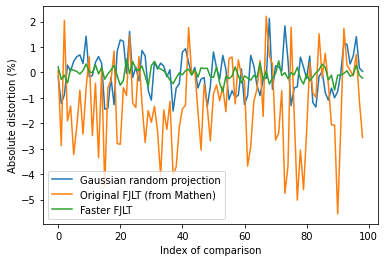

In [8]:
plt.plot(err_gauss * 100, label='Gaussian random projection')
plt.plot(err_mathen * 100, label='Original FJLT (from Mathen)')  # I didn't tune q carefully
plt.plot(err_sfd * 100, label='Faster FJLT')
plt.xlabel('Index of comparison')
plt.ylabel('Absolute distortion (%)')
plt.legend()
plt.show()

# Find compression-error tradeoff of different methods

In [9]:
def run_many_k(A, k_list, method):
    time_hist = np.zeros(len(k_list))
    err_hist = np.zeros(len(k_list))
    for i, k in enumerate(k_list):
        start_time = time.time()
        A_embedded = method(A, k)
        time_hist[i] = time.time() - start_time
        distortion = eval_dist(A, A_embedded)
        err_hist[i] = np.abs(distortion).mean()
    return time_hist, err_hist

In [10]:
k_list = np.arange(1000, 10001, 1000)  # [1000, 2000, ..., 10000]

In [11]:
time_mathen, errhist_mathen = run_many_k(A, k_list, fjlt_mathen)
time_sfd, errhist_sfd = run_many_k(A, k_list, fjlt_sfd)

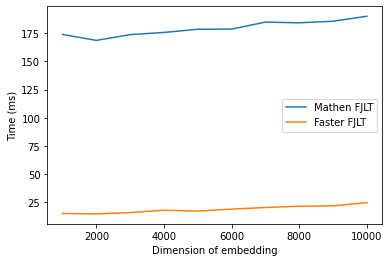

In [12]:
plt.plot(k_list, time_mathen * 1e3, label='Mathen FJLT')
plt.plot(k_list, time_sfd * 1e3, label='Faster FJLT')
plt.xlabel('Dimension of embedding')
plt.ylabel('Time (ms)')
plt.legend()
plt.show()

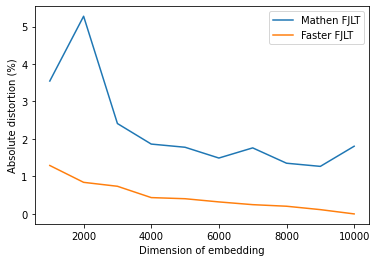

In [13]:
plt.plot(k_list, errhist_mathen * 100, label='Mathen FJLT')
plt.plot(k_list, errhist_sfd * 100, label='Faster FJLT')
plt.xlabel('Dimension of embedding')
plt.ylabel('Absolute distortion (%)')
plt.legend()
plt.show()